In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import glob
import os

from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam


import random
from numpy import asarray
from itertools import repeat

import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow version " + tf.__version__)
print("Keras version " + tf.keras.__version__)

Tensorflow version 2.11.0
Keras version 2.11.0


In [56]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, 
    LeakyReLU, Activation, 
    Concatenate, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow_addons.layers.normalizations import InstanceNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm

In [62]:
# data path
TRAIN_PATH = r'/kaggle/input/mri-flair-png-srgan/MRI_Flair_PNG/train'
VAL_PATH = r'/kaggle/input/mri-flair-png-srgan/MRI_Flair_PNG/val'
TEST_PATH = r'/kaggle/input/mri-flair-png-srgan/MRI_Flair_PNG/test'
data_path = TRAIN_PATH

epochs = 5

# batch size equals to 8 (due to RAM limits)
batch_size = 8

# define the shape of low resolution image (LR) 
low_resolution_shape = (32, 32, 3)

# define the shape of high resolution image (HR) 
high_resolution_shape = (256, 256, 3)

# optimizer for discriminator, generator 
common_optimizer = Adam(0.0002, 0.5)

# use seed for reproducible results
SEED = 2020 
tf.random.set_seed(SEED)

In [77]:
# define hardcoded values used throughout this notebook
IMAGE_SIZE = (256, 256)
IMAGE_SHAPE = (256, 256, 3)


DATASET_PATH = "/kaggle/input/generated-images-xray"
TRAIN_DIR = DATASET_PATH + "/Normal/"
VAL_DIR = DATASET_PATH + "/Normal/"
TEST_DIR = DATASET_PATH + "/Normal/"

NBR_EPOCHS = 100
BATCH_SIZE = 5
MAX_TRAIN_SAMPLES = 200  # restricts training data to this many samples - use for testing and for limited resources


# get the file names in each directory, and count how many files there are
def only_images(ls):
    return [f for f in ls if f.endswith('.jpg')]

train_files = os.listdir(TRAIN_DIR)
val_files = os.listdir(VAL_DIR)

train_files = only_images(train_files)
val_files = only_images(val_files)

train_files = [TRAIN_DIR + "/" + file_path for file_path in train_files]
val_files = [VAL_DIR + "/" + file_path for file_path in val_files]

print(f"{len(train_files)} training files")
print(f"{len(val_files)} validation files")

3820 training files
3820 validation files


In [78]:
def get_train_images(data_path):
    image_list.extend(glob.glob(data_path + '/*'))
    return image_list    

In [79]:
def find_img_dims(image_list):
    
    min_size = []
    max_size = []
    
    for i in range(len(image_list)):
        im = Image.open(image_list[i])
        min_size.append(min(im.size))
        max_size.append(max(im.size))
    
    return min(min_size), max(max_size)

In [80]:
# get min/max image sizes

image_list = train_files
min_size, max_size = find_img_dims(image_list)
print('The min and max image dims are {} and {} respectively.'
      .format(min_size, max_size))

The min and max image dims are 256 and 256 respectively.


## Add Noise and Plot Sample

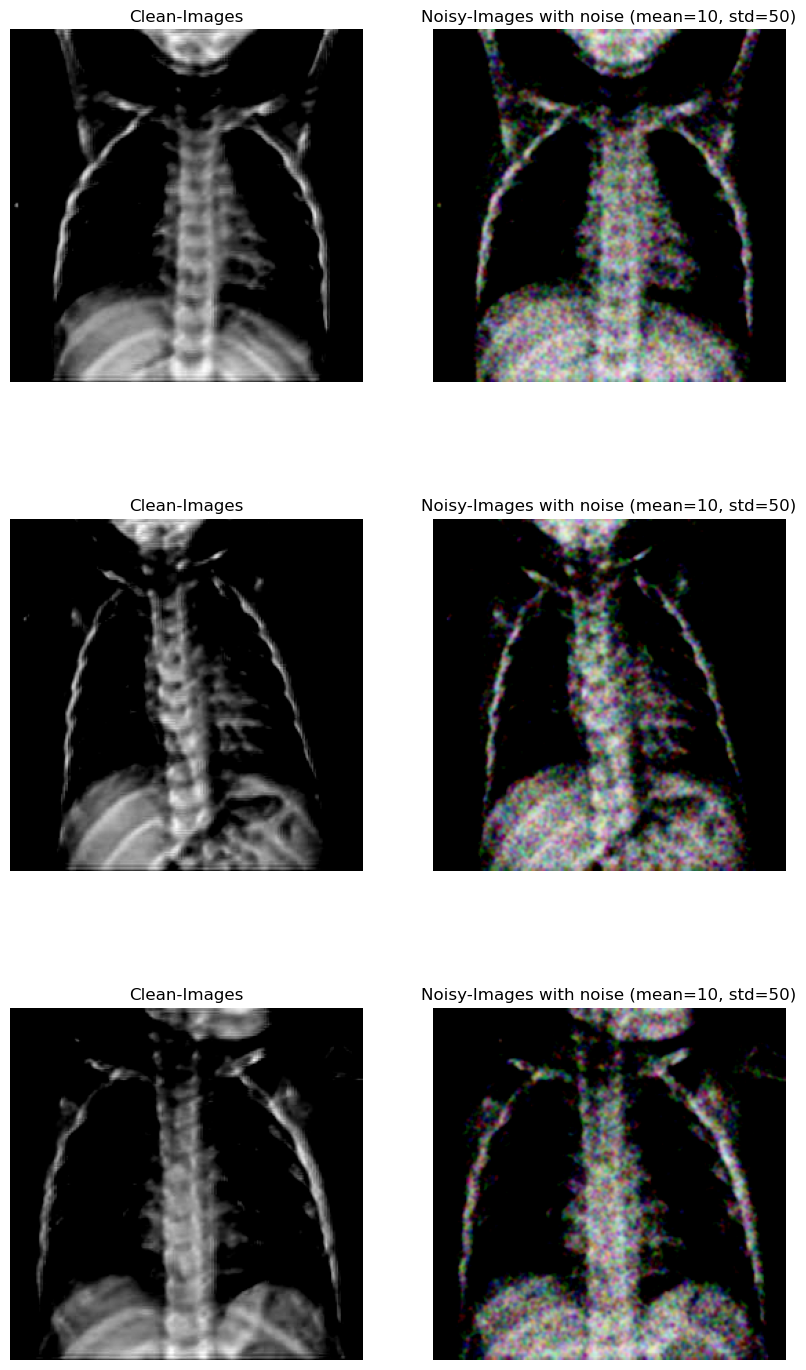

In [81]:
import matplotlib.pyplot as plt
import cv2

def add_noise(image, mean, std):
    rows, cols, channels = image.shape
    noise = np.random.normal(mean, std, (rows, cols, channels))
    return np.clip(image + noise, 0, 255).astype(np.uint8)

def sample_images(image_list, batch_size, noise_mean, noise_std):
    """
    Pre-process a batch of training images
    """
    # image_list is the list of all images
    # random sample a batch of images
    images_batch = np.random.choice(image_list, size=batch_size)
    
    lr_images = []
    hr_images = []
    
    for img in images_batch:
        img1 = imread(img, as_gray=False, pilmode='RGB')
        img1 = img1.astype(np.float32)
        
        # Add noise to the image
        lr_image = add_noise(img1, noise_mean, noise_std)
        
        # Apply Gaussian blur filter
        lr_image = cv2.GaussianBlur(lr_image, (5,5), 0)
        
        # Convert the blurred image to grayscale
        #lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2GRAY)
        
        # Append the original and noisy image to the respective lists
        hr_images.append(img1)
        lr_images.append(lr_image)
                        
    # convert lists into numpy ndarrays
    return np.array(hr_images), np.array(lr_images)


# Define the parameters
batch_size = 3
noise_mean = 10
noise_std = 50

# Sample images and preprocess them
hr_images, lr_images = sample_images(image_list, batch_size=batch_size, noise_mean=noise_mean, noise_std=noise_std)
hr_images = hr_images / 127.5 - 1.
lr_images = lr_images / 127.5 - 1.

# Plot the images
fig, axs = plt.subplots(nrows=batch_size, ncols=2, figsize=(10, 6 * batch_size))

for i in range(batch_size):
    axs[i][0].imshow(hr_images[i])
    axs[i][0].axis('off')
    axs[i][0].set_title('Clean-Images')
    axs[i][1].imshow(lr_images[i])
    axs[i][1].axis('off')
    axs[i][1].set_title(f'Noisy-Images with noise (mean={noise_mean}, std={noise_std})')
plt.show()

## Utility functions

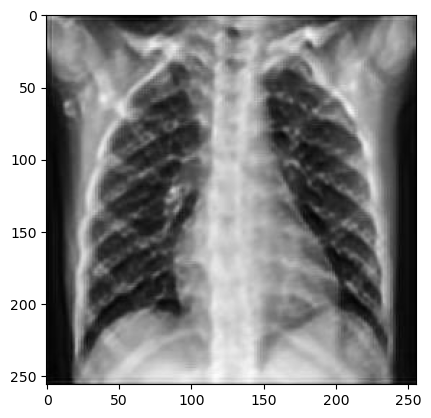

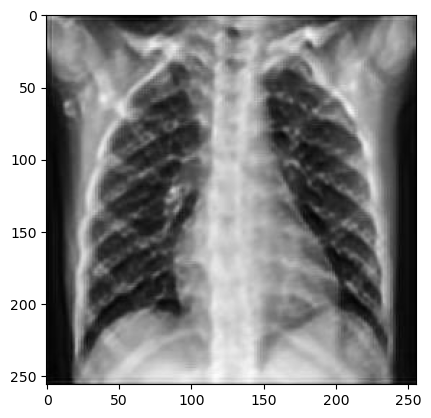

In [82]:
# Resizing image

def resize_image(img, size):
    new_img = cv2.resize(img, size, cv2.INTER_AREA)
    return new_img


img = cv2.imread(train_files[0])
new_img = resize_image(img=img, size=(256,256))
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(new_img, cmap='gray')
plt.show()


In [91]:
class DataLoader():
    def __init__(self, dataset_folder_path, img_size=(256, 256)):
        """
        Constructs a DataLoader object
        
        :params:
            dataset_folder_path (str): The path to the folder of 
                images to be loaded.  This is the name of the Pix2Pix dataset, 
                like edges2shoes.
            image_shape (tuple): Tuple of the image dimensions like (x, y).
        """
        self.dataset_folder_path = dataset_folder_path
        self.img_size = img_size
        self.nbr_batches = None

    def load_data(self, batch_size=1, use_for_training=True):
        """
        Loads data
        """
        image_list = get_train_images(self.dataset_folder_path)
        hr_images, lr_images = sample_images(image_list,
                                             batch_size=batch_size,
                                             noise_mean=10,
                                             noise_std=50)

        # normalize the images
        hr_images = hr_images / 127.5 - 1.
        lr_images = lr_images / 127.5 - 1.

        return hr_images, lr_images

    def load_batch(self, batch_size=1, use_for_training=True):
        """
        A batch load generator
        """
        if use_for_training:
            image_folder_path = self.dataset_folder_path + "/Pneumonia"
        else:
            image_folder_path = self.dataset_folder_path + "/Normal"

        # get a list of the files in the given path
        image_files = os.listdir(image_folder_path)
        image_files = [image_folder_path + "/" + i for i in image_files]
        if MAX_TRAIN_SAMPLES is not None:
            image_files = image_files[:MAX_TRAIN_SAMPLES]
        
        # determine how many batches, based on the number of files 
        #   and the batch size
        self.nbr_batches = int(len(image_files) / batch_size)

        for i in range(self.nbr_batches):
            # load data for this batch
            hr_images, lr_images = self.load_data(batch_size, use_for_training)

            yield hr_images, lr_images


# test the data loader on a single image
loader = DataLoader(
    dataset_folder_path=DATASET_PATH,
    img_size=IMAGE_SIZE
)
train_source, train_target = loader.load_data(batch_size=1, use_for_training=True)
train_source.shape

(1, 256, 256, 3)

In [92]:
# test the data loader on a batch
loader = DataLoader(
    dataset_folder_path=DATASET_PATH,
    img_size=IMAGE_SIZE
)
for batch_nbr, batch in enumerate(loader.load_batch(batch_size=10, use_for_training=False)):
    print('batch nbr', batch_nbr, batch[0].shape, batch[1].shape)

batch nbr 0 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 1 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 2 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 3 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 4 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 5 (10, 256, 256, 3) (10, 256, 256, 3)
batch nbr 6 (10, 256, 256, 3) (10, 256, 256, 3)


ValueError: ImageIO does not generally support reading folders. Limited support may be available via specific plugins. Specify the plugin explicitly using the `plugin` kwarg, e.g. `plugin='DICOM'`

In [93]:
def load_real_samples(batch_size, nbr_patches):
    """
    Uses a DataLoader object to load a batch of real image
    samples.  Returns the source and target images, along with the
    label (label = all ones because they are all real images).
    """
    loader = DataLoader(
        dataset_folder_path=DATASET_PATH,
        img_size=IMAGE_SIZE
    )
    real_source_images, real_target_images = loader.load_data(
        batch_size=batch_size,
        use_for_training=True
    )
    y = np.ones((len(real_source_images), nbr_patches, nbr_patches, 1))
    return [real_source_images, real_target_images], y


# sense check: should see images here
# [x_real_source, x_real_target], y_real = load_real_samples(batch_size=10, nbr_patches=16)
# plt.imshow(x_real_source[0]) # source image (edges)
# plt.show()
# plt.imshow(x_real_target[0]) # target image (shoe)
# plt.show()


def generate_fake_samples(generator, real_source_image_samples, nbr_patches):
    """
    Uses a generator model to generate a batch of fake target image
    samples.  Returns the generated images and their label (label = all
    zeros because they are all fake images).
    """
    fake_target_images = generator.predict(real_source_image_samples)
    y = np.zeros((len(fake_target_images), nbr_patches, nbr_patches, 1))
    return fake_target_images, y

## Build pix2pix and Train

In [94]:
class Pix2Pix:
    def __init__(self, input_image_shape):
        """
        Pix2Pix constructor.

        :params:
            input_image_shape: Tuple of (rows, cols, channels),
                where rows and cols are measured in pixels.  Pix2Pix
                was trained on 256x256x3 shape images, originally.
        """
        self.image_shape = input_image_shape
        self.data_loader = DataLoader(
            dataset_folder_path=DATASET_PATH,
            img_size=input_image_shape[:2]
        )
        # attributes that are defined by methods
        self.discriminator = None
        self.generator = None
        self.discriminator_nbr_patches = None
        self.gan = None

    def _build_discriminator(self):
        """
        The discriminator is a deep CNN that takes the source image
        and target image, and predicts whether the target image is a
        real or fake translation of the source image.
        """
        initial_weights = RandomNormal(stddev=0.02)

        source_image = Input(shape=self.image_shape)
        target_image = Input(shape=self.image_shape)

        combined_images = Concatenate()([source_image, target_image])

        # C64
        x = Conv2D(
            filters=64, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(combined_images)
        x = LeakyReLU(alpha=0.2)(x)
        # C128
        x = Conv2D(
            filters=128, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        # C256
        x = Conv2D(
            filters=256, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        # C512
        x = Conv2D(
            filters=512, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        # second last output layer
        x = Conv2D(
            filters=512, kernel_size=(4, 4),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        # patch output
        x = Conv2D(
            filters=1, kernel_size=(4, 4),
            padding='same',
            kernel_initializer=initial_weights
        )(x)
        patch_out = Activation('sigmoid')(x)
        # define model
        model = Model([source_image, target_image], patch_out)
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(
            loss='binary_crossentropy',
            optimizer=opt,
            loss_weights=[0.5]
        )

        return model

    @staticmethod
    def encoder_block(layer_in, nbr_filters, batch_norm=True):
        """
        Encoder block in the U-net architecture that downsamples
        the input (layer_in) using strided convolution, optionally
        applying batch normalization, and using leaky relu activation.
        """
        initial_weights = RandomNormal(stddev=0.02)

        # downsampling layer
        x = Conv2D(
            filters=nbr_filters, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(layer_in)

        if batch_norm:
            x = BatchNormalization()(x, training=True)

        x = LeakyReLU(alpha=0.2)(x)

        return x

    @staticmethod
    def decoder_block(layer_in, skip_in, nbr_filters, dropout=True):
        """
        Decoder block in the U-net architecture that upsamples the
        the input (layer_in) using strided convolution, batch
        normalization, optional dropout, and relu activation.  The
        skip connection from the encoder must also be added, right
        before the activation.
        """
        initial_weights = RandomNormal(stddev=0.02)

        # add upsampling layer
        x = Conv2DTranspose(
            filters=nbr_filters, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(layer_in)

        # add batch normalization
        x = BatchNormalization()(x, training=True)

        # conditionally add dropout
        if dropout:
            x = Dropout(0.5)(x, training=True)

        # merge with skip connection
        x = Concatenate()([x, skip_in])

        # relu activation
        x = Activation('relu')(x)

        return x

    def _build_generator(self):
        """
        The generator is an encoder-decoder model with a U-net
        architecture.  It takes an image from the source domain
        as input, and generates an image from the target domain
        as output.  The tanh activation produces an output with
        values ranged from -1 to 1.
        """
        initial_weights = RandomNormal(stddev=0.02)

        input_image = Input(shape=self.image_shape)

        # encoder model
        e1 = Pix2Pix.encoder_block(
            layer_in=input_image,
            nbr_filters=64,
            batch_norm=False
        )
        e2 = Pix2Pix.encoder_block(e1, 128)
        e3 = Pix2Pix.encoder_block(e2, 256)
        e4 = Pix2Pix.encoder_block(e3, 512)
        e5 = Pix2Pix.encoder_block(e4, 512)
        e6 = Pix2Pix.encoder_block(e5, 512)
        e7 = Pix2Pix.encoder_block(e6, 512)

        # bottleneck layer
        b = Conv2D(
            filters=512, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(e7)
        b = Activation('relu')(b)

        # decoder model
        d1 = Pix2Pix.decoder_block(
            layer_in=b,
            skip_in=e7,
            nbr_filters=512,
            dropout=True
        )
        d2 = Pix2Pix.decoder_block(d1, e6, 512)
        d3 = Pix2Pix.decoder_block(d2, e5, 512)
        d4 = Pix2Pix.decoder_block(d3, e4, 512, dropout=False)
        d5 = Pix2Pix.decoder_block(d4, e3, 256, dropout=False)
        d6 = Pix2Pix.decoder_block(d5, e2, 128, dropout=False)
        d7 = Pix2Pix.decoder_block(d6, e1, 64, dropout=False)

        # output
        x = Conv2DTranspose(
            filters=3, kernel_size=(4, 4),
            strides=(2, 2),
            padding='same',
            kernel_initializer=initial_weights
        )(d7)
        output_image = Activation('tanh')(x)

        # define model
        model = Model(input_image, output_image)

        return model

    def _build_gan(self):
        """
        Builds the Pix2Pix GAN such that the discriminator trains on
        the real and generated images, while the generator trains
        by means of the discriminator.  The generator updates to minimize
        the L1 loss (error between real and fake images), and the
        adversarial loss (error of the discriminator).  The updates
        weight these losses at a 100:1 ratio in favor of the L1 loss,
        in accordance with the Pix2Pix paper.

        Balancing both losses requires specifying a separate model that
        stacks the generator on the discriminator and feeds a source
        image to both.  Since the output of the generator is also
        the discriminator's target image (which is concatenated with the
        source image as input), the discriminator can predict
        whether the generated image is a real or fake translation of the
        source image.
        """
        source_image = Input(shape=self.image_shape)

        # build discriminator and generator
        self.discriminator = self._build_discriminator()
        self.generator = self._build_generator()

        # store the discriminator output number of patches
        self.discriminator_nbr_patches = self.discriminator.output_shape[1]

        # freeze discriminator weights for this combined model
        self.discriminator.trainable = False

        # map inputs and outputs
        generator_output = self.generator(source_image)
        discriminator_output = self.discriminator([source_image, generator_output])

        # model takes source image as input,
        # produces generated image and real/fake prediction as output
        model = Model(source_image, [discriminator_output, generator_output])

        model.compile(
            loss=['binary_crossentropy', 'mae'],
            optimizer=Adam(lr=0.0002, beta_1=0.5),
            loss_weights=[1, 100]
        )

        return model
    
    def save_samples(self, epoch, batch_i):
        """
        Saves samples of source, target, and generated images to the 
        generated_images directory.
        """
        os.makedirs('generated_images/', exist_ok=True)
        r, c = 3, 3
        
        # load source and target images, and generate a fake image
        source_imgs, target_imgs = self.data_loader.load_data(batch_size=3, use_for_training=False)
        fake_imgs = self.generator.predict(target_imgs)
        
        # combine them and rescale them to range from 0 to 1
        gen_imgs = np.concatenate([target_imgs, fake_imgs, source_imgs])
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("generated_images/%d_%d.png" % (epoch, batch_i))
        plt.close()

    def train(self, nbr_epochs, batch_size, sample_interval=100):
        """
        Trains the GAN.  In each iteration, the discriminator is first
        updated with real samples, and then with fake/generated samples.
        Then the generator is updated.
        """
        # build the GAN
        self.gan = self._build_gan()
        
        for epoch in range(nbr_epochs):

            print("Epoch", epoch, "of", nbr_epochs)
            d_loss_real_hist, d_loss_fake_hist, g_loss_hist = [], [], []

            for batch_i, (x_real_source, x_real_target) in enumerate(
                self.data_loader.load_batch(batch_size)
            ):
                # create corresponding real labels
                y_real = np.ones((
                    len(x_real_source), 
                    self.discriminator_nbr_patches,
                    self.discriminator_nbr_patches,
                    1
                ))
                
                # generate a batch of fake samples
                x_fake_target, y_fake = generate_fake_samples(
                    generator=self.generator, 
                    real_source_image_samples=x_real_source, 
                    nbr_patches=self.discriminator_nbr_patches
                )
                
                # update discriminator for real samples
                d_loss_real = self.discriminator.train_on_batch(
                    [x_real_source, x_real_target], 
                    y_real
                )
                d_loss_real_hist.append(d_loss_real)
                
                # update discriminator for generated samples
                d_loss_fake = self.discriminator.train_on_batch(
                    [x_real_source, x_fake_target], 
                    y_fake
                )
                d_loss_fake_hist.append(d_loss_fake)
                
                # update the generator
                g_loss, _, _ = self.gan.train_on_batch(
                    x_real_source, 
                    [y_real, x_real_target]
                )
                g_loss_hist.append(g_loss)
                
                # store sample images
                if batch_i % sample_interval == 0:
                    self.save_samples(epoch=epoch, batch_i=batch_i)

            # show performance on epoch (indent this block for batch level performance)
            print(
                f"Epoch {epoch+1} batch {batch_i+1} performance:\n", 
                f"Discriminator real loss: {d_loss_real} \n",
                f"Discriminator fake loss: {d_loss_fake} \n",
                f"Generator loss: {g_loss} \n"
            )

        # return the loss hist for the final epoch
        return d_loss_real_hist, d_loss_fake_hist, g_loss_hist
    
    def save_generator(self):
        """
        Saves a trained Pix2Pix generator model to a h5 file.
        """
        filename = "pix2pix_generator_model.h5"
        self.generator.save(filename)


p2p = Pix2Pix(input_image_shape=IMAGE_SHAPE)
d_loss_real, d_loss_fake, g_loss = p2p.train(
    nbr_epochs=NBR_EPOCHS, 
    batch_size=BATCH_SIZE,
    sample_interval=10
)
p2p.save_generator()

Epoch 0 of 100
1/1 [==============================] - 2s 2s/step


KeyboardInterrupt: 